# Python

## Reading ACE Files
To interact with nuclear data, we first need to read in an ACE file. ACE stands for A Compact ENDF. This if the format which many Monte Carlo codes (such as MCNP and Serpent) use for nuclear data. First we need to import the PapillonNDL library into Python, then we will read in a pre-prepared data file for U235.

In [1]:
from pyPapillonNDL import *
U235ACE = ACE("U235.300c")

With the ACE file read into memory, we can access the raw data in this manner should we so desire. We can get basic information such as whether the nuclide is fissile, the temerature at which the evaluation was prepared (given in kelvin !), and the atomic weight ratio.

In [2]:
print("U235 is fissile: %r" %U235ACE.fissile())
print("Atomic Weight Ratio of U235 is %.5f" %U235ACE.awr())
print("This evaluation was prepared at %.3f kelvin" %U235ACE.temperature())

U235 is fissile: True
Atomic Weight Ratio of U235 is 233.02480
This evaluation was prepared at 300.000 kelvin


It is also possible to access the JXS, NXS, and XSS blocks directly. All values from the JXS and NXS blocks are given as integers, while values in the XSS block are given as floats (even if they are provided as a integer in the file).

In [3]:
len_of_xss = U235ACE.nxs(0)
segment_of_xss = U235ACE.xss(0, 5)
print("Length of NXS block is %i" %len_of_xss)
print("First 5 elements of the XSS: %r" %segment_of_xss)

Length of NXS block is 4524241
First 5 elements of the XSS: [1e-11, 1.0625e-11, 1.125e-11, 1.1875e-11, 1.25e-11]


Most of the time however, interacting with the raw ACE file is not very desireable. For ACE files which contain continuous energy neutron data, you can construct a `CENeutron` object, which allows for interaction with the data in a more natural manner. This object provides similar access to the temperature, and AWR, as well as cross sections and secondary energy distributions.

In [4]:
U235 = CENeutron(U235ACE)

## Evaluating and Plotting Cross Sections
From the `CENeutron` object, it is possible to quickly query the value of a cross section at any given energy (provided in units of MeV).

In [5]:
print("Total XS at 0.3 MeV = %.5f barns" %U235.total_xs(0.3))
print("Elastic Scattering XS at 0.3 MeV = %.5f barns" %U235.elastic_xs(0.3))
print("Disappearance XS at 0.3 MeV = %.5f barns" %U235.disappearance_xs(0.3))

Total XS at 0.3 MeV = 9.74688 barns
Elastic Scattering XS at 0.3 MeV = 7.13012 barns
Disappearance XS at 0.3 MeV = 0.21780 barns


You can also look-up the cross section for a specific MT reaction. For example, fission corresponds with MT=18, so to get the fission cross section of U235 at 0.3 MeV, we can use

In [6]:
print("Fission XS at 0.3 MeV = %.5f barns" %U235.reaction_xs(18, 0.3))

Fission XS at 0.3 MeV = 1.23070 barns


One of the most time consuming parts of looking-up a cross sections is locating the appropriate location in the energy grid. PapillonNDL implements the hashing method, which allows for a quick lookup of the energy index. This index can be provided as an optional argument, to speed up evaluations. If an energy grid index is not provided, binary search will be used to find the appropriate location in the grid.

In [7]:
indx = U235.energy_grid_index(1.4)
print("Total XS at 1.4 MeV = %.5f barns" %U235.total_xs(1.4, indx))

Total XS at 1.4 MeV = 6.74889 barns


PapillonNDL also makes it really easy to plot cross sections. To do this, we get instances of the `CrossSection` objects which we want to plot (such as total, fission, etc.), and we can then access the data as lists.

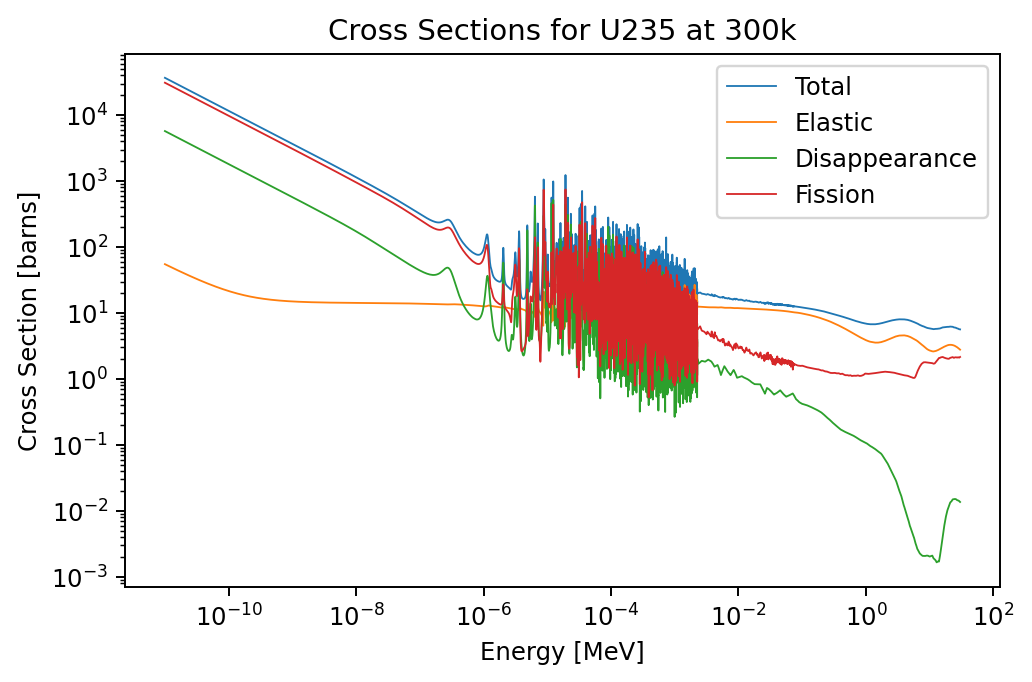

In [8]:
totalxs = U235.total_cross_section()
elastxs = U235.elastic_cross_section()
disxs = U235.disappearance_cross_section()

if U235.has_reaction(18):
    fissxs = U235.reaction(18).cross_section()

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 175
energy_grid = totalxs.energy()
plt.plot(energy_grid, totalxs.xs(), label='Total', linewidth=0.75)
plt.plot(energy_grid, elastxs.xs(), label='Elastic', linewidth=0.75)
plt.plot(energy_grid, disxs.xs(), label='Disappearance', linewidth=0.75)
if U235.has_reaction(18):
    plt.plot(energy_grid, fissxs.xs(), label='Fission', linewidth=0.75)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Cross Section [barns]')
plt.title('Cross Sections for U235 at %ik' %int(U235.temperature()))
plt.tight_layout()
plt.legend()

In the above example, we used the `has_reaction` method, to make sure that the our U235 evaluation did indeed contain the fission cross section data. While this is obvious for MT=18 and U235, you may not be sure if a certain nuclide evaluation has the data for a given MT reaction. This allows you to check that the reaction data is provided before you try to access it, to avoid error.

## Interacting with Reaction Data
Cross sections aren't the only type of reaction data we are interested though. For reactions which produce secondary neutrons (inelastic scattering, and others such as (n,2n)), there are distributions which are used to sample the secondary particle's energy and angle. Some reactions also have energy dependent yield. All of this data is contained in the `Reaction` class. You can check to see if a `CENeutron` instance has a particluar reaction MT and then get that reaction using:

In [9]:
if U235.has_reaction(16):
    n2n = U235.reaction(16)

Here, `n2n` contains all the data for the MT=16 (n,2n) reaction for U235. We can get the threshold energy for the reaction to occur, the yield as a function of energy, the cross section, and the secondary distributions.

In [10]:
n2n_threshold = n2n.threshold()
print("(n,2n) threshold for U235 = %.3f MeV" %n2n_threshold)

# The C++ method 'yield' cannot be used in Python as it is a keyword.
# Here, we must use the method name 'multiplicity'.
print("Yield at %.3f MeV = %.f" %(n2n_threshold,n2n.multiplicity(n2n_threshold)))

# The 'frame' method provides the reference frame for the reaction data.
# 'Frame.Lab' refers to the laboratory frame, and 'Frame.CM' refers to the
# center of mass frame
if n2n.frame() == Frame.CM:
    print("(n,2n) reaction data is provided in the center of mass frame.")

(n,2n) threshold for U235 = 5.321 MeV
Yield at 5.321 MeV = 2
(n,2n) reaction data is provided in the center of mass frame.


We can easily sample the secondary distributions from reactions. All that must be provided is an incident energy, and a random number generator function, and the reaction will return an `AngleEnergyPacket` which contains the sampled cosine of the scattering angle, and outgoing energy *both in the LABORATORY frame*. PapillonNDL will convert all data sampled from reactions to the lab frame automatically. While not provided in the C++ version of the library, the Python version comes with a simple random number generator function by the name of `rng`. We can use that here to sample an energy and angle.

In [11]:
scatter_data = n2n.sample_angle_energy(6., rng)
print("Cosine of scattering angle = %.5f" %scatter_data.cosine_angle)
print("Scattered energy = %.5f MeV" %scatter_data.energy)

Cosine of scattering angle = 0.55257
Scattered energy = 0.38519 MeV


We can even retrieve the angle-energy distribution for the reaction to take a closer look at the data if we want.

In [12]:
angle_energy = n2n.angle_energy()
print(type(angle_energy))

<class 'pyPapillonNDL.TabularEnergyAngle'>


Through the magic of Pybind11, Python will know the true type of distribution automatically, so you know how to look at it. To learn more about all of the different distribution types, try looking at the Library API documentation.

One thing we will look at though, is plotting angular distributions. The `AngularDistribution` for elastic scattering is not kept in a reaction, but in the CENeutron instance. We can look at the number of incident energies, and then get the `AngleLaw` corresponding to a particular incident energy.

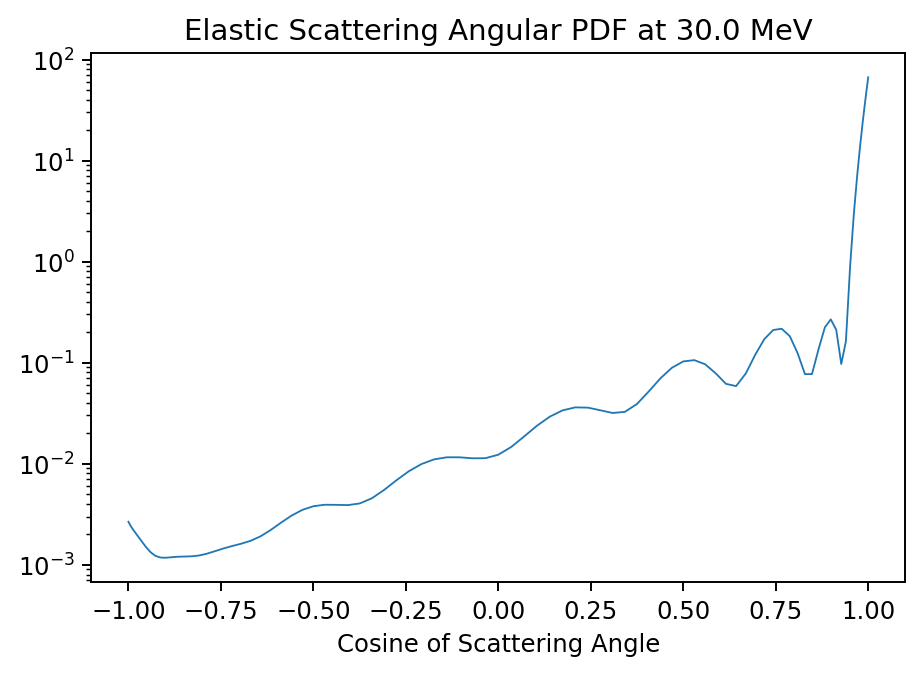

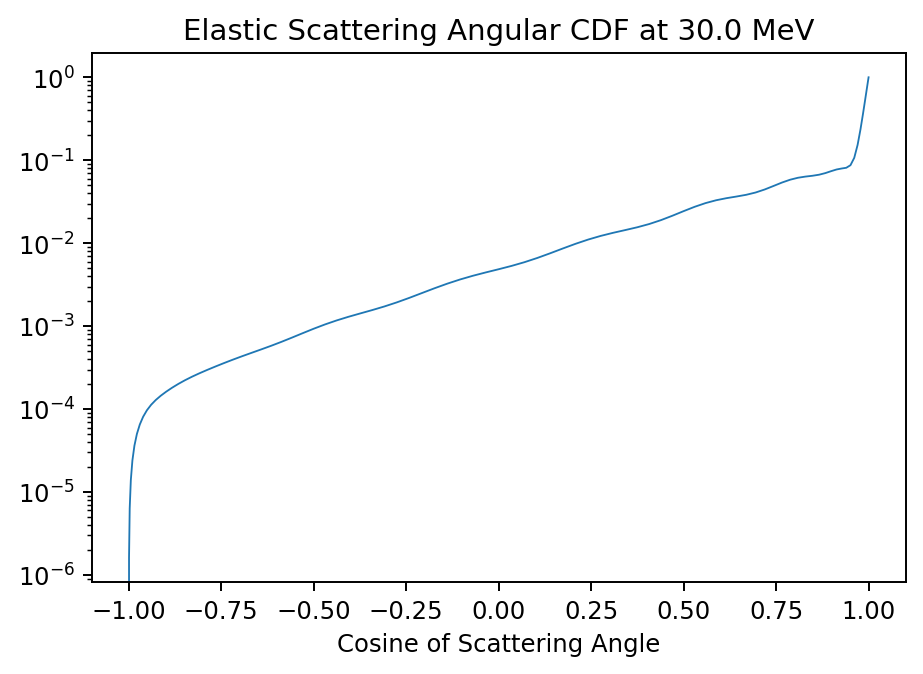

In [13]:
elastic_ad = U235.elastic_angle_distribution()
angular_law = elastic_ad.law(elastic_ad.size()-1)
law_energy = elastic_ad.energy(elastic_ad.size()-1)

if isinstance(angular_law, AngleTable):
    plt.plot(angular_law.cosines(), angular_law.pdf(), linewidth=0.75)
    plt.yscale('log')
    plt.xlabel('Cosine of Scattering Angle')
    plt.title('Elastic Scattering Angular PDF at %.1f MeV' %law_energy)
    plt.show()
    
    plt.plot(angular_law.cosines(), angular_law.cdf(), linewidth=0.75)
    plt.yscale('log')
    plt.xlabel('Cosine of Scattering Angle')
    plt.title('Elastic Scattering Angular CDF at %.1f MeV' %law_energy)
    plt.show()

## Fission Data and Delayed Groups
Data related to fission, such as the average number of neutrons emitted per fission, the number of delayed groups, and the delayed group information are held in the `FissionData` class.

In [14]:
fissdata = U235.fission_data()

print("Total   nu at 0.005 MeV = %.3f" %fissdata.nu_total(0.005))
print("Prompt  nu at 0.005 MeV = %.3f" %fissdata.nu_prompt(0.005))
print("Delayed nu at 0.005 MeV = %.3f" %fissdata.nu_delayed(0.005))

Total   nu at 0.005 MeV = 2.422
Prompt  nu at 0.005 MeV = 2.406
Delayed nu at 0.005 MeV = 0.016


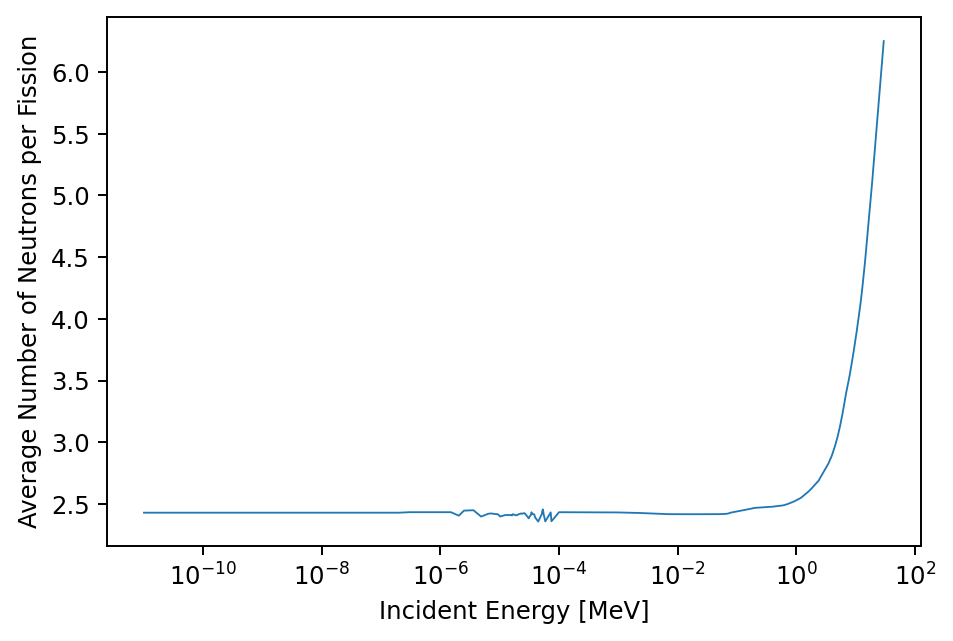

In [15]:
nu = fissdata.nu_total()
plt.plot(nu.x(), nu.y(), linewidth=0.75)
plt.xlabel('Incident Energy [MeV]')
plt.ylabel('Average Number of Neutrons per Fission')
plt.xscale('log')
plt.show()

The promp spectrum can be easily sampled in the a similar manner as for sampling secondary particle data from reaction:

In [16]:
E = 1.E-8
prompt_neutron = fissdata.sample_prompt_angle_energy(E, rng)

print("Prompt neutron cosine : %.3f" %prompt_neutron.cosine_angle)
print("Prompt neutron energy : %.3f MeV" %prompt_neutron.energy)

Prompt neutron cosine : -0.104
Prompt neutron energy : 0.326 MeV


A `DelayedGroup` contains the decay constant for precursors, and the probability that a precursor is born into that group for a given incident neutron energy. This is also where you will find the energy distributions for delayed neutrons. Delayed neutrons are always isotropic, and therefore, only the energy is sampled, and not the angle.

In [17]:
print("U235 has %i delayed neutron groups." %fissdata.ngroups())

U235 has 6 delayed neutron groups.


In [18]:
dg1 = fissdata.delayed_group(1)
print("Probability of being in group 1: %.5f" %dg1.probability(E))
print("Decaye Constant for group 1: %.5f [1/s]" %dg1.decay_constant())
print("Sampled delayed neutron energy: %.5f MeV" %dg1.sample_energy(E, rng))

Probability of being in group 1: 0.18070
Decaye Constant for group 1: 0.03274 [1/s]
Sampled delayed neutron energy: 0.41347 MeV


## Conclusions
Here, only a small taste of the PapillonNDL Python binds have been demonstrated. If you are interested in learning more, I encourage you to look at the Library API documentation. This is generated from the C++ header files, but all of the class names and methods are the same (with the exception of the C++ `Reaction` method `yield` which is called `multiplicity` in Python, as yield is a keyword in the language). It will provide more information about all of the options available for each distribution type, and how to access it.